In [125]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

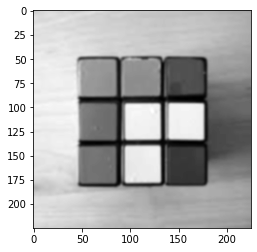

In [126]:
image_orig = cv.imread('sample_3.jpg', cv.IMREAD_COLOR)
image_gray = cv.cvtColor(image_orig, cv.COLOR_BGR2GRAY)
image_blur = cv.GaussianBlur(image_gray, (5, 5), 0)
plt.imshow(image_blur, cmap='gray')

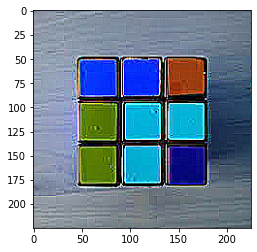

In [127]:
def sharpen_image(image):
    filter = np.asarray([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpen_image = cv.filter2D(image, -1, filter)

    return sharpen_image

def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

image_sharp = sharpen_image(image_orig)
plt.imshow(image_sharp)
image_blur = image_sharp

In [129]:
import cv2
import numpy as np
from imutils import contours

image = cv2.imread('sample_3.jpg')
original = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
mask = np.zeros(image.shape, dtype=np.uint8)

colors = {
    'gray': ([76, 0, 41], [179, 255, 70]),        # Gray
    'blue': ([69, 120, 100], [179, 255, 255]),    # Blue
    'yellow': ([21, 110, 117], [45, 255, 255]),   # Yellow
    'orange': ([0, 110, 125], [17, 255, 255])     # Orange
    }

# Color threshold to find the squares
open_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
close_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
for color, (lower, upper) in colors.items():
    lower = np.array(lower, dtype=np.uint8)
    upper = np.array(upper, dtype=np.uint8)
    color_mask = cv2.inRange(image, lower, upper)
    color_mask = cv2.morphologyEx(color_mask, cv2.MORPH_OPEN, open_kernel, iterations=1)
    color_mask = cv2.morphologyEx(color_mask, cv2.MORPH_CLOSE, close_kernel, iterations=5)

    color_mask = cv2.merge([color_mask, color_mask, color_mask])
    mask = cv2.bitwise_or(mask, color_mask)

gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# Sort all contours from top-to-bottom or bottom-to-top
(cnts, _) = contours.sort_contours(cnts, method="top-to-bottom")

# Take each row of 3 and sort from left-to-right or right-to-left
cube_rows = []
row = []
for (i, c) in enumerate(cnts, 1):
    row.append(c)
    if i % 3 == 0:  
        (cnts, _) = contours.sort_contours(row, method="left-to-right")
        cube_rows.append(cnts)
        row = []

# Draw text
number = 0
for row in cube_rows:
    for c in row:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)

        cv2.putText(original, "#{}".format(number + 1), (x,y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
        number += 1

cv2.imshow('mask', mask)
cv2.imwrite('mask.png', mask)
cv2.imshow('original', original)
cv2.waitKey()
cv.destroyAllWindows()

13

In [128]:
image_thresh = cv.adaptiveThreshold(image_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 15, 2)
plt.imshow(image_thresh, cmap='gray')

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\thresh.cpp:1674: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'cv::adaptiveThreshold'


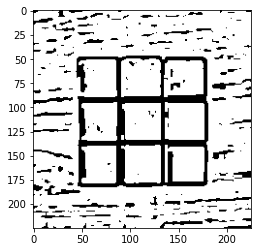

In [ ]:
kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
image_morph = cv.morphologyEx(image_thresh, cv.MORPH_OPEN, kernel, iterations=1)
plt.imshow(image_morph, cmap='gray')

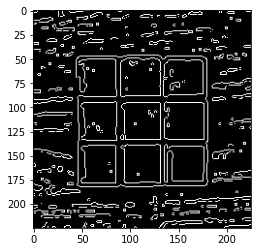

In [ ]:
image_edges = cv.Canny(image_morph, 100, 200)
plt.imshow(image_edges, cmap='gray')

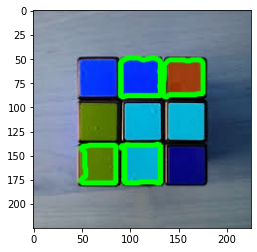

In [ ]:
image_height, image_width = image_orig.shape[:2]
min_area_thresh = int(round(image_width * image_height * 0.0001))

contours, hierarchy = cv.findContours(
    image_edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE
)

def is_contour_valid(contour):
    area = cv.contourArea(contour)
    if area < min_area_thresh:
        return False

    epsilon = 0.1 * cv.arcLength(contour, closed=True)
    approx = cv.approxPolyDP(contour, epsilon, closed=True)

    if len(approx) != 4:
        return False
    
    _, _, width, height = cv.boundingRect(contour)
    box_area = width * height
    area_perc_diff = 0.2
    if not ((1 - area_perc_diff) < box_area / area < (1 + area_perc_diff)):
        return False
    
    side_perc_diff = 0.2
    if not ((1 - side_perc_diff) < width / height < (1 + side_perc_diff)):
        return False

    return True

valid_contours = list(filter(is_contour_valid, contours))
image = image_orig.copy()
cv.drawContours(
    image, valid_contours, -1, (0, 255, 0), thickness=3, lineType=cv.LINE_AA
)

plt.imshow(image)